# **Task 5**
**Classification of parties involved in patent litigation as organization, individual or unknown.**

This is an unsupervised classification problem which can be solved by the clustering technique. First, we preprocess the data and try to extract some common features which can be used to distinguish data. Since these features might be correlated to each other, so we will perform Principal Component Analysis (PCA) which will return the uncorrelated vectors and also reduce the dimension of our feature space. Then, we can plot the output in two-dimensional space and expect to see distinct clusters. Now, we can apply the k-means clustering algorithm to form the clusters and label them according to our output labels.

It is divided into the following sections:
- Getting the necessary libraries & data
- Preprocessing the data
- Performing feature engineering to extract features
- Training a model to perform PCA and clustering

# **Importing libraries & reading data**

In [ ]:
#importing all the necessary libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from collections import Counter

#reading the data
df = pd.read_csv('https://raw.githubusercontent.com/sg-dev/assignment_PhDposition/master/task5_data/patent_litigation_parties.csv')

# **Data preprocessing**


- We want to remove all the '.' and ',' since it does not provide any meaningful information to the model.

- We also want to convert all the text to lowercase later for feature extraction.

In [ ]:
text = [i.replace('.','').replace(',','') for i in df['name']] #removing delimiter
text_lower = [i.lower() for i in text]                         #converting to lowercase

# **Feature engineering**

In this section, we will extract four different features which will help us to distinguish the data.

**Feature 1** : Common words

One of our desired labels is organization. So we will use the domain knowledge of the organization to classify the text which contains words related to this.

In [ ]:
word = ['corporation', 'compan', 'international', 'bv', 'communication', 'solution', 'inc', 'llc', 
        ' lp', 'plc', 'service', 'research','group','corp','incorporate','bank','university','limited',
        'ltd','co','publication','production', 'ag','service','system', 'associate','group','industr',
        'gmbh','entertainment','laborator', 'technolog','health','manufactur']

f1=[int(any([1 if(j in i) else 0 for j in word])) for i in text_lower]      #storing 1 if the text contains any of these words, otherwise 0

**Feature 2** : No. of words

Total no. of words in the text can be used as one of the features since for example; an individual name will have less no. of words than the organization or unknown.

In [ ]:
f2= [len(i.split()) for i in text]    #storing total no. of words in the text

**Feature 3** : Part of speech tagging

Now, we are interested in tagging each word of the text as noun, verb, digit, etc. This will help us to extract much of the information from the text. This feature is divided into 5 subfeatures:

- Noun : count total no. of nouns in the text (both common & proper noun)
- Verbs : count total no. of verbs in the text
- Digit : count total no. of numeric value in the text
- Determiner : words like to, in, below, etc
- Adjective : adjectives to the noun

In [ ]:
noun = []
verb = []
digit = []
determiner = []
adjective = []

for i in text:
  tokens = nltk.word_tokenize(i)                  #tokenizing the text
  tokens_text = nltk.Text(tokens)
  tags = nltk.pos_tag(tokens_text)                #tagging the tokens
  counts = Counter(tag for word,tag in tags)      #counting the tags

  #counting different kinds of tags in different categories
  noun_sf = (counts['NN'],counts['NNS'],counts['NNP'],counts['NNPS'])                                     
  verb_sf = (counts['VB'],counts['VBD'],counts['VBG'],counts['VBN'],counts['VBP'],counts['VBZ'])
  digit_sf =(counts['CD'],0)
  determiner_sf =(counts['DT'],counts['IN'])
  adjective_sf = (counts['JJ'],counts['JJR'],counts['JJS'],counts['RB'],counts['RBR'],counts['RBS'])

  noun.append(sum(noun_sf))
  verb.append(sum(verb_sf))
  digit.append(sum(digit_sf))
  determiner.append(sum(determiner_sf))
  adjective.append(sum(adjective_sf))

**Feature 4** : No. of words starting with uppercase

Let us take an example, individual names or company will have more no. of words starting with uppercase letter than unknown text. So, we can use it as a feature.

In [ ]:
f4 = [sum(1 for c in i.split(" ") if c[0].isupper()) for i in df['name']]     #storing total no. of words starting with uppercase letter

**Combining all the features to a new dataframe**

Now, we will create a new dataframe consists of all the 4 features and their subfeatures. We will also normalize the content to the maximum value of the feature.


In [ ]:
listOfStr = ["commonwords", "wordcount", "noun", "verb", "digit", "determiner", "adjective", "capitalcount"]
temp = [f1, f2, noun,verb,digit,determiner,adjective,f4]
df_features = pd.DataFrame (dict(zip(listOfStr, temp)), columns = listOfStr)          #creating a new dataframe and adding all the features

for i in listOfStr:
  df_features[i] = df_features[i]/df_features[i].max()                                #normalizing all the features
df_features.head()                                                                    #print first 5 entries of the dataframe

,commonwords,wordcount,noun,verb,digit,determiner,adjective,capitalcount
0,1.0,0.238095,0.384615,0.00,0.0,0.000000,0.000000,0.357143
1,0.0,0.142857,0.076923,0.25,0.0,0.142857,0.000000,0.000000
2,0.0,0.142857,0.076923,0.25,0.0,0.142857,0.000000,0.000000
3,1.0,0.142857,0.230769,0.00,0.0,0.000000,0.000000,0.214286
4,1.0,0.142857,0.076923,0.00,0.0,0.142857,0.333333,0.000000


# **Training a model**

**Principal Component Analysis**

The clustering algorithm cannot be used directly to extracted features because of the following reasons:
- Some of the features are correlated with each other. So, it is important to do first perform correlation analysis before applying the algorithm. 
- The features are 8-dimensional space, and it is very difficult to form clusters in high dimensional space by the algorithm. So, we have to reduce the dimensions of the feature space to two, so that we can also analytically see the clusters and apply clustering algorithm. 

To solve the above problems, we perform PCA. It is a technique for reducing the dimensionality of datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

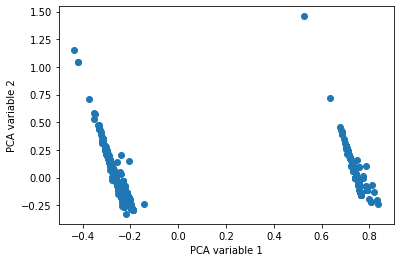

In [ ]:
pca = PCA(n_components=2)                                             #initialize an object by defining the desired uncorrelated variables
principalComponents = pca.fit_transform(df_features)
plt.scatter(principalComponents[:,0], principalComponents[:,1])       #plotting the uncorrelated variables in 2D space
plt.xlabel('PCA variable 1')
plt.ylabel('PCA variable 2')
plt.show()

**k-means clustering**

k-means algorithm is an iterative algorithm that tries to partition the dataset into k predefined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. 

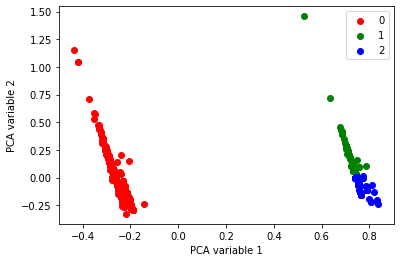

In [ ]:
true_k = 3                                                                                      #define no. of required clusters to be formed
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=1,random_state=5)      #defining a model by initializing KMeans object 
model.fit(principalComponents)

color = ['r','g','b']
for i in range(0,3):                                                                            #plotting the PCA variables in 2D space where colour defines the formed clusters
  plt.scatter(principalComponents[model.labels_ == i,0], principalComponents[model.labels_ == i,1], c=color[i], label=i)
plt.xlabel('PCA variable 1')
plt.ylabel('PCA variable 2')
plt.legend()
plt.show()

# **Saving to .csv file**

In [ ]:
listOfStr = ["party_row_count", "name", "class"]
temp = [df['party_row_count'], df['name'], model.labels_]
saving = pd.DataFrame (dict(zip(listOfStr, temp)), columns = listOfStr)             #creating a new dataframe for .csv file

labels = ['organization','individual','unknown']                                    #desired labels
for i in range (3):
  saving['class'] = saving['class'].replace(i,labels[i])                            #converting k-means labels to the desired labels

saving.to_csv(r'task5.csv')                                                         #saving the dataframe to .csv file